# Mix EMA & Couple candlesticks & Momentum - Strategy - Backtesting 

In [278]:
# Giu nguyen Rule Long-Short cu, optimize QTY

### Import Library

In [279]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)
from backtesting import set_bokeh_output
set_bokeh_output(notebook=False)

### Load Price Data

In [280]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [281]:
data = dataset.copy()

In [282]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [283]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-07 14:15:00,1343.3,1344.4,1342.4,1344.2,5075
2025-02-07 14:20:00,1344.2,1344.7,1343.6,1344.0,4865
2025-02-07 14:25:00,1344.1,1344.2,1342.8,1343.3,5013


In [284]:
def get_ema_signal(r):
    signal = ''
    if r['ema_fast_s1'] < r['ema_low_s1'] and r['ema_fast'] > r['ema_low']:
        signal = 'long'
    elif r['ema_fast_s1'] > r['ema_low_s1'] and r['ema_fast'] < r['ema_low']:
        signal = 'short'
    return signal

In [285]:
def set_condition_1(r):
    cond = ''
    if r['Open'] > r['Close'] >= r['Low'] + 0.1:
        # Do va co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] <= r['High'] - 0.1:
        # Xanh va co bong nen tren
        cond = 'long'
    return cond


def set_condition_2(r):
    cond = ''
    if r['Open'] > r['Close'] == r['Low'] and r['Low'] < r['low_s1']:
        # Do va khong co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] == r['High'] and r['High'] > r['high_s1']:
        # Xanh va khong co bong nen tren
        cond = 'long'
    return cond
    

def get_couple_candleticks_signal(r):
    signal = ''
    if r['condition_1'] == 'short' and r['condition_2'] == 'short':
        signal = 'short'
    elif r['condition_1'] == 'long' and r['condition_2'] == 'long':
        signal = 'long'
    return signal

In [286]:
def cal_signal(row):
    signal = ''
    if not row['first_close']:
        return signal
    if row['Close'] - row['prev_low'] > 21 or row['prev_high'] - row['Close'] > 21:
        return signal
    if row['mom_y'] > 0.26 and row['body_rate'] > .65:
        signal = 'long'
    elif row['mom_y'] < -.18 and row['body_rate'] < -.39:
        signal = 'short'
    return signal


def cal_first_close(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 915]
    if not tick.empty:
        return tick[0]


def cal_high_before(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute < 1345]
    return tick.max()


def cal_low_before(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute < 1355]
    return tick.min()


def cal_last(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 1445]
    if not tick.empty:
        return tick[0]

def cal_price(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 1355]
    if not tick.empty:
        return tick[0]
        
def get_day_data(htd):
    data_tmp = htd.copy()
    data_tmp['first_close'] = data_tmp.Close
    data_tmp['_2pm_price'] = data_tmp.Close
    data_tmp['_last'] = data_tmp.Close
    data_tmp['prev_high'] = data_tmp.High
    data_tmp['prev_low'] = data_tmp.Low
    day_data = data_tmp.resample("D").agg({
        'first_close': cal_first_close,
        'prev_high': cal_high_before,
        'prev_low': cal_low_before,
        '_2pm_price': cal_price,
        '_last': cal_last
    }).rename(columns={'_last': 'day_Close'})
    day_data.dropna(subset=['day_Close'], inplace=True)
    day_data['prev_day_Close'] = day_data['day_Close'].shift(1)
    day_data.drop(columns=['day_Close'], inplace=True)
    return day_data[['prev_day_Close', 'first_close', 'prev_high', 'prev_low']]

def add_momentum_signal(data):
    clone_data = data.copy()
    day_data = get_day_data(clone_data)
    clone_data = clone_data.assign(time_d=pd.PeriodIndex(clone_data.index, freq='1D').to_timestamp())
    df_merged = pd.merge(clone_data, day_data, left_on="time_d", right_index=True, how="left")
    # df_merged = clone_data.merge(day_data, how='left', left_index=True, right_index=True)
    df_merged['mom_y'] = df_merged.apply(lambda r: 100 * (r['Close'] - r['prev_day_Close']) / r['prev_day_Close'] if r['first_close'] else 0, axis=1)
    df_merged['body_rate'] = df_merged.apply(lambda r: (r['Close'] - r['first_close']) / (r['prev_high'] - r['prev_low']) if r['first_close'] else 0, axis=1)
    df_merged['momentum_signal'] = df_merged.apply(lambda r: cal_signal(r), axis=1)
    df_merged.loc[100 * df_merged.index.hour + df_merged.index.minute != 1355, 'momentum_signal'] = ''
    return df_merged
    

In [287]:
def prepare_data(data):
    data["current"] = data.index + pd.DateOffset(minutes=5)
    # EMA signal
    data['max_in_range'] = data['High'].rolling(10).max()
    data['min_in_range'] = data['Low'].rolling(10).min()
    data["ema_superfast"] = ta.ema(data["Close"], length=10)
    data["ema_fast"] = ta.ema(data["Close"], length=20)
    data["ema_low"] = ta.ema(data["Close"], length=250)
    data['ema_fast_s1'] = data['ema_fast'].shift(1)
    data['ema_low_s1'] = data['ema_low'].shift(1)
    data['ema_signal'] = data.apply(lambda r: get_ema_signal(r), axis=1)
    # Couple candlesticks signal
    data['low_s1'] = data['Low'].shift(1)
    data['high_s1'] = data['High'].shift(1)
    data['max_5'] = data['High'].rolling(5).max()
    data['min_5'] = data['Low'].rolling(5).min()
    data['condition_1'] = data.apply(lambda r: set_condition_1(r), axis=1)
    data['condition_1'] = data['condition_1'].shift(1)
    data['condition_2'] = data.apply(lambda r: set_condition_2(r), axis=1)
    data['couple_cs_signal'] = data.apply(lambda r: get_couple_candleticks_signal(r), axis=1)
    # Momentum signal
    data = add_momentum_signal(data)
    # Optimnize
    data['Close_s1'] = data['Close'].shift(1)
    data["ATR_14"] = ta.atr(data['High'], data['Low'], data['Close'], length=14)
    data['RSI_14'] = ta.rsi(data["Close"], length=14)
    data['price_move'] = data.apply(lambda r: r['Close'] - r['Close_s1'] - 0.5 * r['ATR_14'] , axis=1)
    return data

In [288]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-07 14:15:00,1343.3,1344.4,1342.4,1344.2,5075
2025-02-07 14:20:00,1344.2,1344.7,1343.6,1344.0,4865
2025-02-07 14:25:00,1344.1,1344.2,1342.8,1343.3,5013


In [289]:
prepared_data = prepare_data(data)
prepared_data.dropna(subset=['Close', 'price_move', 'ATR_14'],inplace=True)

In [290]:
prepared_data

,Open,High,Low,Close,Volume,current,max_in_range,min_in_range,ema_superfast,ema_fast,...,first_close,prev_high,prev_low,mom_y,body_rate,momentum_signal,Close_s1,ATR_14,RSI_14,price_move
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-02 10:10:00,899.9,899.9,898.9,899.7,1883,2020-11-02 10:15:00,901.4,897.7,899.547675,NaN,...,898.6,901.5,895.4,NaN,0.180328,,899.5,1.294225,50.983431,-0.447112
2020-11-02 10:15:00,899.6,901.5,899.6,901.2,2305,2020-11-02 10:20:00,901.5,897.7,899.848098,NaN,...,898.6,901.5,895.4,NaN,0.426230,,899.7,1.358712,61.004215,0.820644
2020-11-02 10:20:00,901.1,901.2,899.3,899.3,1796,2020-11-02 10:25:00,901.5,897.7,899.748444,NaN,...,898.6,901.5,895.4,NaN,0.114754,,901.2,1.414385,47.701558,-2.607193
2020-11-02 10:25:00,899.1,900.3,898.8,899.9,1917,2020-11-02 10:30:00,901.5,897.7,899.775999,NaN,...,898.6,901.5,895.4,NaN,0.213115,,899.3,1.422923,51.312174,-0.111461
2020-11-02 10:30:00,900.0,900.1,899.3,900.0,1150,2020-11-02 10:35:00,901.5,897.7,899.816727,NaN,...,898.6,901.5,895.4,NaN,0.229508,,899.9,1.362514,51.908107,-0.581257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-07 14:15:00,1343.3,1344.4,1342.4,1344.2,5075,2025-02-07 14:20:00,1347.4,1341.2,1343.886991,1342.719356,...,1335.2,1347.4,1335.0,0.320919,0.725806,,1343.1,1.610891,59.371201,0.294554
2025-02-07 14:20:00,1344.2,1344.7,1343.6,1344.0,4865,2025-02-07 14:25:00,1347.4,1342.0,1343.907538,1342.841322,...,1335.2,1347.4,1335.0,0.305993,0.709677,,1344.2,1.574399,58.322974,-0.987199
2025-02-07 14:25:00,1344.1,1344.2,1342.8,1343.3,5013,2025-02-07 14:30:00,1347.4,1342.4,1343.797076,1342.885006,...,1335.2,1347.4,1335.0,0.253750,0.653226,,1344.0,1.561942,54.683896,-1.480971


In [291]:
backtest_data = prepared_data[['Open', 'Close', 'High', 'Low', 'min_in_range', 'max_in_range', 'min_5', 'max_5', 'ema_signal', 'momentum_signal', 'couple_cs_signal', 'price_move', 'RSI_14']]
backtest_data[(backtest_data.ema_signal != '') | (backtest_data.momentum_signal != '') | (backtest_data.couple_cs_signal != '')]

,Open,Close,High,Low,min_in_range,max_in_range,min_5,max_5,ema_signal,momentum_signal,couple_cs_signal,price_move,RSI_14
Date,,,,,,,,,,,,,
2020-11-02 14:25:00,904.9,907.0,907.0,904.5,896.6,907.0,896.6,907.0,,,long,1.317357,68.216746
2020-11-03 09:20:00,908.5,908.1,908.8,908.1,897.4,909.4,908.1,909.4,,,short,-1.397001,64.301187
2020-11-04 09:35:00,907.8,907.3,908.0,907.3,907.3,909.9,907.3,908.8,,,short,-0.963274,47.205851
2020-11-04 10:05:00,908.2,909.0,909.0,908.1,906.7,909.0,906.8,909.0,,,long,0.008284,57.591408
2020-11-04 10:15:00,910.2,911.5,911.5,909.8,906.7,911.5,907.6,911.5,,,long,0.879332,68.726453
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-05 13:15:00,1332.2,1331.6,1332.5,1331.6,1331.0,1333.4,1331.5,1332.6,,,short,-1.018566,39.652233
2025-02-05 13:25:00,1331.7,1330.9,1332.1,1330.9,1330.9,1332.6,1330.9,1332.6,,,short,-1.119835,35.314688
2025-02-05 13:50:00,1331.9,1333.4,1333.4,1331.5,1329.6,1333.4,1329.6,1333.4,,,long,1.115998,56.905957


In [292]:
backtest_data[backtest_data.momentum_signal != '']

,Open,Close,High,Low,min_in_range,max_in_range,min_5,max_5,ema_signal,momentum_signal,couple_cs_signal,price_move,RSI_14
Date,,,,,,,,,,,,,
2020-11-04 13:55:00,912.8,916.3,917.2,912.5,912.1,917.2,912.4,917.2,,long,,2.896133,66.296297
2020-11-06 13:55:00,908.3,907.3,908.4,906.7,903.3,908.6,903.5,908.6,,short,,-1.430087,48.557803
2020-11-11 13:55:00,914.3,915.6,915.7,914.0,914.0,921.2,914.0,921.0,,short,,0.561457,33.870686
2020-11-13 13:55:00,931.6,932.9,933.4,931.2,929.2,933.4,929.2,933.4,,long,,0.687694,72.912131
2020-11-16 13:55:00,928.2,933.5,933.8,928.2,925.5,936.3,925.5,934.0,,short,,3.920265,52.238208
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-10 13:55:00,1307.2,1309.3,1309.3,1306.2,1305.2,1310.4,1305.2,1309.3,,short,,1.192188,45.525926
2025-01-17 13:55:00,1312.9,1315.4,1316.7,1312.8,1309.6,1316.7,1310.8,1316.7,,long,,1.828070,74.301638
2025-01-21 13:55:00,1317.6,1319.4,1319.9,1317.6,1316.6,1324.4,1316.6,1320.3,,short,,1.231248,33.960691


In [293]:
backtest_data

,Open,Close,High,Low,min_in_range,max_in_range,min_5,max_5,ema_signal,momentum_signal,couple_cs_signal,price_move,RSI_14
Date,,,,,,,,,,,,,
2020-11-02 10:10:00,899.9,899.7,899.9,898.9,897.7,901.4,898.1,901.4,,,,-0.447112,50.983431
2020-11-02 10:15:00,899.6,901.2,901.5,899.6,897.7,901.5,898.6,901.5,,,,0.820644,61.004215
2020-11-02 10:20:00,901.1,899.3,901.2,899.3,897.7,901.5,898.9,901.5,,,,-2.607193,47.701558
2020-11-02 10:25:00,899.1,899.9,900.3,898.8,897.7,901.5,898.8,901.5,,,,-0.111461,51.312174
2020-11-02 10:30:00,900.0,900.0,900.1,899.3,897.7,901.5,898.8,901.5,,,,-0.581257,51.908107
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-07 14:15:00,1343.3,1344.2,1344.4,1342.4,1341.2,1347.4,1342.4,1346.5,,,,0.294554,59.371201
2025-02-07 14:20:00,1344.2,1344.0,1344.7,1343.6,1342.0,1347.4,1342.4,1346.5,,,,-0.987199,58.322974
2025-02-07 14:25:00,1344.1,1343.3,1344.2,1342.8,1342.4,1347.4,1342.4,1346.5,,,,-1.480971,54.683896


In [294]:
class MainStrategy(Strategy):
    max_sl = 3.5
    #
    ema_trailing_sl = 5.5
    ema_tp_step = 27
    #
    momentum_trailing_sl = 4.5
    momentum_tp_step = 27
    #
    cs_trailing_sl = 7.5
    cs_tp_step = 27
    #
    def init(self):
        self._broker._cash = 5500
        self.strategy = ''
        super().init()

    def next(self):
        super().next()
        close_price = self.data.Close[-1]
        # Strategy trailing stoploss
        if self.strategy == 'ema':
            if self.position.is_long:
                max_in_range = self.data.max_in_range[-1]
                if close_price < max_in_range - self.ema_trailing_sl:
                    self.strategy = ''
                    self.position.close()
            elif self.position.is_short:
                min_in_range = self.data.min_in_range[-1]
                if close_price > min_in_range + self.ema_trailing_sl:
                    self.strategy = ''
                    self.position.close()
        elif self.strategy == 'couple_cs':
            if self.position.is_long:
                max_5 = self.data.max_5[-1]
                if close_price < max_5 - self.cs_trailing_sl:
                    self.strategy = ''
                    self.position.close()
            elif self.position.is_short:
                min_5 = self.data.min_5[-1]
                if close_price > min_5 + self.cs_trailing_sl:
                    self.strategy = ''
                    self.position.close()

        # Close deal at 14:00
        if self.strategy == 'couple_cs' or self.strategy == 'momentum':
            _time = self.data.index
            current_time = _time[-1]
            if current_time.hour == 14 and current_time.minute >= 25:
                if self.position.is_long or self.position.is_short:
                    self.strategy = ''
                    self.position.close()
                return
            
        # Main Strategy
        ema_signal = self.data.ema_signal[-1]
        momentum_signal = self.data.momentum_signal[-1]
        couple_cs_signal = self.data.couple_cs_signal[-1]
        if self.position:
            # return
            if self.strategy != 'ema':
                if self.position.is_long and ema_signal == 'long':
                    self.strategy = 'ema'
                elif self.position.is_short and ema_signal == 'short':
                    self.strategy = 'ema'
        else:
            rsi = self.data.RSI_14[-1]
            if ema_signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.ema_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                self.strategy = 'ema'
            elif ema_signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.ema_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                self.strategy = 'ema'
            elif momentum_signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.momentum_tp_step
                self.buy(size=3, sl=sl, tp=tp)
                # print(f'sl: {sl}, tp: {tp}')
                self.strategy = 'momentum'
            elif momentum_signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.momentum_tp_step
                self.sell(size=3, sl=sl, tp=tp)
                self.strategy = 'momentum'
                # print(f'sl: {sl}, tp: {tp}')
            elif couple_cs_signal == 'long':
                # print('couple_cs_signal')
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.cs_tp_step
                self.buy(size=3, sl=sl, tp=tp)
                self.strategy = 'couple_cs'
            elif couple_cs_signal == 'short':
                # print('couple_cs_signal2')
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.cs_tp_step
                self.sell(size=3, sl=sl, tp=tp)
                self.strategy = 'couple_cs'

In [295]:
bt = Backtest(backtest_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [296]:
stats

Start                     2020-11-02 10:10:00
End                       2025-02-07 14:45:00
Duration                   1558 days 04:35:00
Exposure Time [%]                   48.263332
Equity Final [$]                   8930.13762
Equity Peak [$]                    8963.60568
Return [%]                          62.366139
Buy & Hold Return [%]               49.305324
Return (Ann.) [%]                   12.207289
Volatility (Ann.) [%]                6.050581
Sharpe Ratio                          2.01754
Sortino Ratio                        4.521073
Calmar Ratio                         3.307586
Max. Drawdown [%]                   -3.690694
Avg. Drawdown [%]                   -0.293148
Max. Drawdown Duration      129 days 03:20:00
Avg. Drawdown Duration        3 days 21:05:00
# Trades                                 1623
Win Rate [%]                         37.58472
Best Trade [%]                       3.309918
Worst Trade [%]                     -0.910953
Avg. Trade [%]                    

In [297]:
stats['_trades'].tail(20)

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
1603,-3,53283,53293,1323.90271,1319.7,12.60813,0.003174,2025-01-07 13:40:00,2025-01-07 14:30:00,None,0 days 00:50:00
1604,3,53300,53308,1318.19534,1314.2,-11.98602,-0.003031,2025-01-08 09:25:00,2025-01-08 10:05:00,None,0 days 00:40:00
1605,-3,53310,53315,1311.90631,1315.7,-11.38107,-0.002892,2025-01-08 10:15:00,2025-01-08 10:40:00,None,0 days 00:25:00
1606,-3,53359,53395,1321.20352,1311.9,27.91056,0.007042,2025-01-09 10:05:00,2025-01-09 14:30:00,None,0 days 04:25:00
1607,-3,53424,53446,1311.00658,1295.6,46.21974,0.011752,2025-01-10 11:15:00,2025-01-10 14:30:00,None,0 days 03:15:00
1608,3,53466,53471,1292.38760,1288.5,-11.66280,-0.003008,2025-01-13 10:30:00,2025-01-13 10:55:00,None,0 days 00:25:00
1609,3,53490,53497,1295.18844,1298.0,8.43468,0.002171,2025-01-13 13:55:00,2025-01-13 14:30:00,None,0 days 00:35:00
1610,-3,53502,53548,1295.01138,1290.2,14.43414,0.003715,2025-01-14 09:15:00,2025-01-14 14:30:00,None,0 days 05:15:00
1611,3,53607,53622,1308.19234,1304.2,-11.97702,-0.003052,2025-01-16 09:30:00,2025-01-16 10:45:00,None,0 days 01:15:00
1612,-1,53635,53652,1300.20982,1308.9,-8.69018,-0.006684,2025-01-16 13:15:00,2025-01-17 09:00:00,None,0 days 19:45:00


In [298]:
stats['_trades']['PnL'].min()

-28.53960000000029

In [299]:
trades = stats['_trades']

In [300]:
trades['PnL'].sum()

3430.137620000162

In [301]:
trades[(trades.EntryTime > '2023-01-01 00:00:00') & (trades.EntryTime < '2024-01-01 00:00:00')]['PnL'].sum()

778.376580000026

In [302]:
trades[(trades.EntryTime > '2022-01-01 00:00:00') & (trades.EntryTime < '2023-01-01 00:00:00')]['PnL'].sum()

1273.5229300000456

In [303]:
trades[trades.PnL < -3.1]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,3,35,36,906.97201,904.0,-8.91603,-0.003277,2020-11-02 14:30:00,2020-11-02 14:45:00,None,0 days 00:15:00
1,-3,42,86,907.92754,909.0,-3.21738,-0.001181,2020-11-03 09:25:00,2020-11-03 14:30:00,None,0 days 05:05:00
2,-3,96,103,907.02781,910.8,-11.31657,-0.004159,2020-11-04 09:40:00,2020-11-04 10:15:00,None,0 days 00:35:00
11,-3,626,642,935.71920,939.6,-11.64240,-0.004147,2020-11-18 11:30:00,2020-11-18 14:15:00,None,0 days 02:45:00
13,-3,706,735,946.91584,950.6,-11.05248,-0.003891,2020-11-20 09:40:00,2020-11-20 13:30:00,None,0 days 03:50:00
...,...,...,...,...,...,...,...,...,...,...,...
1612,-1,53635,53652,1300.20982,1308.9,-8.69018,-0.006684,2025-01-16 13:15:00,2025-01-17 09:00:00,None,0 days 19:45:00
1614,-3,53797,53803,1318.70427,1321.3,-7.78719,-0.001968,2025-01-21 14:00:00,2025-01-21 14:30:00,None,0 days 00:30:00
1619,-3,54017,54021,1321.50343,1325.3,-11.38971,-0.002873,2025-02-04 09:40:00,2025-02-04 10:00:00,None,0 days 00:20:00
1620,-3,54030,54034,1321.90331,1325.8,-11.69007,-0.002948,2025-02-04 10:45:00,2025-02-04 11:05:00,None,0 days 00:20:00


In [304]:
trades[trades.PnL < -3.1]['PnL'].sum()

-9344.632949999901

In [305]:
len(trades[trades.PnL < -3.1]) * -3.1

-2824.1

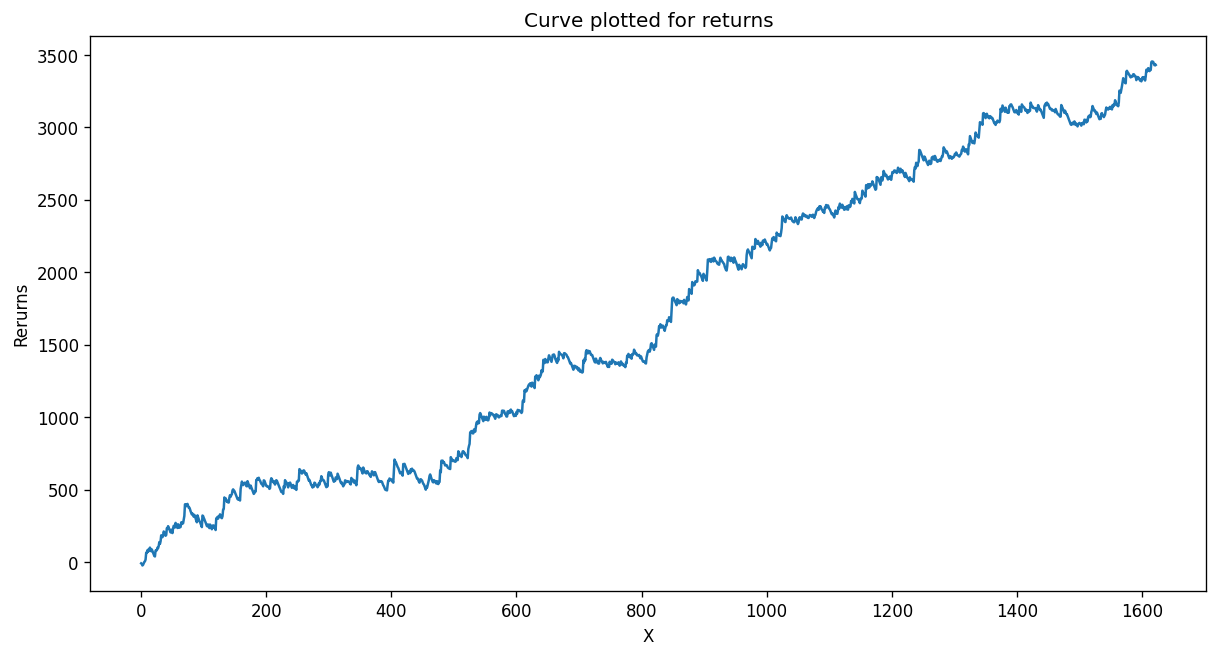

In [306]:
copy_trades = trades.copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

In [307]:
trades[trades.EntryTime > '2024-01-01 00:00:00']['PnL'].sum()

634.0127300000386

## Optimize profit